## This notebook implements two-way grid square to lat/lon conversion.

Based on description at https://en.wikipedia.org/wiki/Maidenhead_Locator_System

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import string
import numpy as np
import pandas as pd

In [ ]:
# Create string lookup lists for each of the codes.
alpha_upper = np.char.array([x for x in string.ascii_uppercase])
alpha_lower = np.char.array([x for x in string.ascii_lowercase])
nr_str      = np.char.array(['{!s}'.format(x) for x in range(10)])

In [ ]:
def latlon2gridsquare(lat,lon,precision=6):
    """
    Calculates gridsquares from lat,lon pairs.
    This routine is vectorized.
    
    Precision indicates the desired number of Grid Square characters,
    and must be an even number. 4 is often used in HF communications,
    and 6 is standard for VHF/UHF. Any two locations within the same 
    6-character grid square are no more than 12 km apart.
    """
    #### Pre-process
    lats = np.array(lat)
    lons = np.array(lon)
    
    # Make sure all input lons are between -180 and +180 deg.
    tf = lons > 180.
    lons[tf] -= 360.

    # Define zLats that start at 0 at the south pole
    # Define zLons that start at 0 at the antimeridian of Greenwich
    zLats = lats +  90.
    zLons = lons + 180.


    # Calculate the field (a.k.a. first 2 letters)
    base = 18.
    container_size_lat = 180.
    container_size_lon = 360.
    subdivide_size_lat = container_size_lat / base
    subdivide_size_lon = container_size_lon / base

    zLats_rem        = zLats % container_size_lat
    zLons_rem        = zLons % container_size_lon

    lat_code_inx     = np.array(np.floor(zLats_rem / subdivide_size_lat),dtype=np.int)
    lon_code_inx     = np.array(np.floor(zLons_rem / subdivide_size_lon),dtype=np.int)

    lon_code  = alpha_upper[lon_code_inx]
    lat_code  = alpha_upper[lat_code_inx]
    this_code = lon_code + lat_code

    grid_square = this_code
    curr_prec   = 2

    # Square, subsquare, extended square, and beyond...
    while curr_prec < precision:
        # Determine if we use base 10 numerics for base 24 alpha
        # for this portion of the code.
        alpha        = not bool((curr_prec/2) % 2)
        if alpha:
            base     = 24
            str_code = alpha_lower
        else:
            base     = 10.
            str_code = nr_str

        container_size_lat     = subdivide_size_lat
        container_size_lon     = subdivide_size_lon
        subdivide_size_lat     = container_size_lat / base
        subdivide_size_lon     = container_size_lon / base

        zLats_rem        = zLats_rem % container_size_lat
        zLons_rem        = zLons_rem % container_size_lon

        lat_code_inx     = np.array(np.floor(zLats_rem / subdivide_size_lat),dtype=np.int)
        lon_code_inx     = np.array(np.floor(zLons_rem / subdivide_size_lon),dtype=np.int)

        lon_code    = str_code[lon_code_inx]
        lat_code    = str_code[lat_code_inx]
        this_code   = lon_code + lat_code
        grid_square = grid_square + this_code
        curr_prec  += 2
        
    return grid_square

In [3]:
def gridsquare2latlon(gridsquare):
    """
    Calculates lat,lon pairs from gridsquares.
    This routine is vectorized.
    """
    # Make everything lower case and put into a character array
    # for easy slicing.
    gss = np.char.array(gridsquare).lower()

    # Create string lookup lists for each of the codes.
    alpha_pd = pd.Series(range(26),index=alpha_lower)

    # Make sure precision of array is uniform.
    precs = np.array([len(x) for x in gss])
    precision = precs.max()
    if np.unique(precs).size != 1:
        # If a vector of gridsqaures is given without uniform precision,
        # there should be a subroutine to pad the gridsquares with less
        # to the center of the cell. e.g. FN20 --> FN20mm
        raise('All input grid squares must be of same precision.')

    # Seed values for field calculation.
    base               = 18.
    container_size_lat = 180.
    container_size_lon = 360.
    
    # Loop to do actual calculation
    pos, zLat, zLon    = 0,0.,0.
    while pos < precision:
        # Get the 2 characters of the grid square we will work on.
        tmp_0 = gss.ljust(pos+2)
        tmp_1 = gss.ljust(pos)
        if pos == 0: tmp_1[:] = ''
        code  = tmp_0.lstrip(tmp_1)

        lon_code = code.ljust(1)
        lat_code = code.lstrip(lon_code)

        # Convert code into an index number and choose a base.
        alpha        = not bool(pos/2 % 2)
        if alpha:
            lon_inx = np.array(alpha_pd.loc[lon_code].tolist(),dtype=np.float)
            lat_inx = np.array(alpha_pd.loc[lat_code].tolist(),dtype=np.float)
            if pos != 0: base = 24.
        else:
            lon_inx = np.array(lon_code,dtype=np.float)
            lat_inx = np.array(lat_code,dtype=np.float)
            base = 10.

        # Determine resolution for this loop.
        subdivide_size_lat = container_size_lat / base
        subdivide_size_lon = container_size_lon / base

        # Add contribution of this loop to zLat and zLon.
        # zLat --> latitude, but south pole is 0 deg
        # zLon --> longitude, but antimeridian of Greenwich is 0 deg
        zLat += (subdivide_size_lat * lat_inx)
        zLon += (subdivide_size_lon * lon_inx)

        # Interate to next to characters in the grid square.
        container_size_lat = subdivide_size_lat
        container_size_lon = subdivide_size_lon
        pos += 2

    # Convert zLat,zLon to lat,lon.
    lat = zLat -  90.
    lon = zLon - 180.
    
    return lat,lon

In [10]:
def gridsquare_grid(precision=4):
    """
    Generate a grid of gridsquares up to an arbitrary precision.
    """
    
    # Figure out the size of dLat and dLon for a specified precision.
    N = 1.
    for curr_zPrec in range(precision/2):
        if curr_zPrec == 0:
            # Field case... base 18
            N = N * 18.
        elif curr_zPrec % 2 == 1:
            # Number case... base 10
            N = N * 10.
        else:
            # Alpha case... base 24
            N = N * 24

    dLon = 360./N
    dLat = 180./N

    # Calculate vectors of lats/lons for the desired precsion.
    grid_squares = []
    lons = np.arange(0,360,dLon) - 180. + dLon/2.
    lats = np.arange(0,180,dLat) -  90. + dLat/2.

    # Turn the vectors into a mesh grid and calculate the grid squares.
    lat_grd,lon_grd = np.meshgrid(lats,lons)
    grid_grid = latlon2gridsquare(lat_grd,lon_grd,precision=precision)
    
    return grid_grid

## Testing

In [4]:
# Some sample grid square - lat/lon pairs.
test_dct          = {}

tmp               = {}
test_dct['aa7bq'] = tmp
tmp['lat']        =   33.698256
tmp['lon']        = -111.891495
tmp['gs']         = 'DM43bq'

tmp               = {}
test_dct['w2naf'] = tmp
tmp['lat']        =  40.811667
tmp['lon']        = -74.210000
tmp['gs']         = 'FN20vt'

tmp               = {}
test_dct['k2mff'] = tmp
tmp['lat']        =  40.7429
tmp['lon']        = -74.1770
tmp['gs']         = 'FN20vr'

# Put everything into numpy arrays to test multiple conversions.
lats, lons, gss = [], [], []
for key,item in test_dct.iteritems():
    lats.append(item['lat'])
    lons.append(item['lon'])
    gss.append(item['gs'])

In [5]:
test_dct

{'aa7bq': {'gs': 'DM43bq', 'lat': 33.698256, 'lon': -111.891495},
 'k2mff': {'gs': 'FN20vr', 'lat': 40.7429, 'lon': -74.177},
 'w2naf': {'gs': 'FN20vt', 'lat': 40.811667, 'lon': -74.21}}

In [6]:
# Test a single location - W2NAF (40.811667, -74.210000, FN20vt)
grid_square = latlon2gridsquare(40.811667, -74.210000)
print 'Grid Square: ', grid_square

# Test multiple locations
grid_square = latlon2gridsquare(lats,lons)
print 'Grid Square: ', grid_square

Grid Square:  FN20vt
Grid Square:  ['FN20vt' 'FN20vr' 'DM43bq']


In [7]:
# Test a single location - W2NAF (40.811667, -74.210000, FN20vt)
lat,lon = gridsquare2latlon('FN20vt')
print '(lat, lon): ', lat,lon

# Test multiple locations
lat,lon = gridsquare2latlon(gss)
print '(lat, lon): ', lat,lon

(lat, lon):  [ 40.79166667] [-74.25]
(lat, lon):  [ 40.79166667  40.70833333  33.66666667] [ -74.25        -74.25       -111.91666667]


## Map Demonstrations

In [8]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

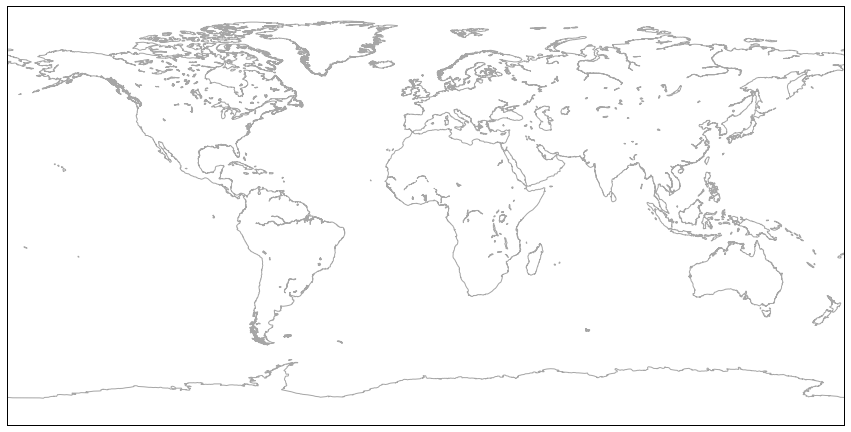

In [9]:
llcrnrlon = -180.
llcrnrlat =  -90.
urcrnrlon =  180.
urcrnrlat =   90.

fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)
m   = Basemap(llcrnrlon=llcrnrlon,llcrnrlat=llcrnrlat,urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            resolution='l',area_thresh=1000.,projection='cyl',ax=ax)

# draw parallels and meridians.
#m.drawparallels(np.arange( -90., 91.,45.),color='k',labels=[False,True,True,False])
#m.drawmeridians(np.arange(-180.,181.,45.),color='k',labels=[True,False,False,True])
m.drawcoastlines(color='0.65')
m.drawmapboundary(fill_color='w')

plt.show()

In [11]:
grid_grid = gridsquare_grid()
print grid_grid.shape
print grid_grid[0,0]
print grid_grid[-1,-1]

(180, 180)
AA00
RR99


In [12]:
grid_grid

chararray([['AA00', 'AA01', 'AA02', ..., 'AR07', 'AR08', 'AR09'],
       ['AA10', 'AA11', 'AA12', ..., 'AR17', 'AR18', 'AR19'],
       ['AA20', 'AA21', 'AA22', ..., 'AR27', 'AR28', 'AR29'],
       ..., 
       ['RA70', 'RA71', 'RA72', ..., 'RR77', 'RR78', 'RR79'],
       ['RA80', 'RA81', 'RA82', ..., 'RR87', 'RR88', 'RR89'],
       ['RA90', 'RA91', 'RA92', ..., 'RR97', 'RR98', 'RR99']], 
      dtype='|S4')